# CIFAR-10 CNN

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 60.000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 classes com 6.000 imagens por classe. 

O exemplo abaixo é uma adaptação do exemplo fornecido na documentação do Keras: 
https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py Nele, nós utilizamos apenas 3 das 10 classes. A saída das diferentes camadas da CNN são mostradas.

## Importando as bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sys, os

import copy
import time

import pickle
import torch
import torchvision

import torch.nn as nn

from torch.autograd import Variable
from collections import OrderedDict
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

#np.random.seed(1337)  # for reproducibility

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Carregando e mostrando os dados (seleciona apenas as classes 0, 1 e 2)

In [3]:
from torchvision.datasets import CIFAR10

CIFAR_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class CIFARX(CIFAR10):
    def __init__(self, root, classes, train=True, **kwargs):
        super(CIFARX, self).__init__(root, train, **kwargs)
        
        # check wrong parameters
        if not isinstance(classes, list):
            raise Exception('Argument classes must be a list')
        
        if max(classes) > 9 or min(classes) < 0:
            raise Exception('Value of elements in classes must be in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]')
        
        new_data = []
        new_labels = []
        if train:
            for i, label in enumerate(self.train_labels):
                if label in classes:
                    new_data.append(self.train_data[i])
                    new_labels.append(label)
                    
            new_data = np.array(new_data)
            self.train_data = new_data
            self.train_labels = new_labels
        else:  # test set
            for i, label in enumerate(self.test_labels):
                if label in classes:
                    new_data.append(self.test_data[i])
                    new_labels.append(label)

            new_data = np.array(new_data)
            self.test_data = new_data
            self.test_labels = new_labels           
        
        self.classes = np.array(CIFAR_CLASSES)[classes]

In [27]:
images_dir = '../data/CIFAR10/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados são normalizados)
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    'train': CIFARX(images_dir, [0, 1, 2], train=True, transform=data_transforms['train'], download=True),
    'val': CIFARX(images_dir, [0, 1, 2], train=False, transform=data_transforms['val'], download=True),
}

print('amostras para treinamento:', len(image_datasets['train']))
print('amostras para validação:', len(image_datasets['val']))

Files already downloaded and verified
Files already downloaded and verified
amostras para treinamento: 15000
amostras para validação: 3000


## Mostrando algumas imagens do conjunto de teste

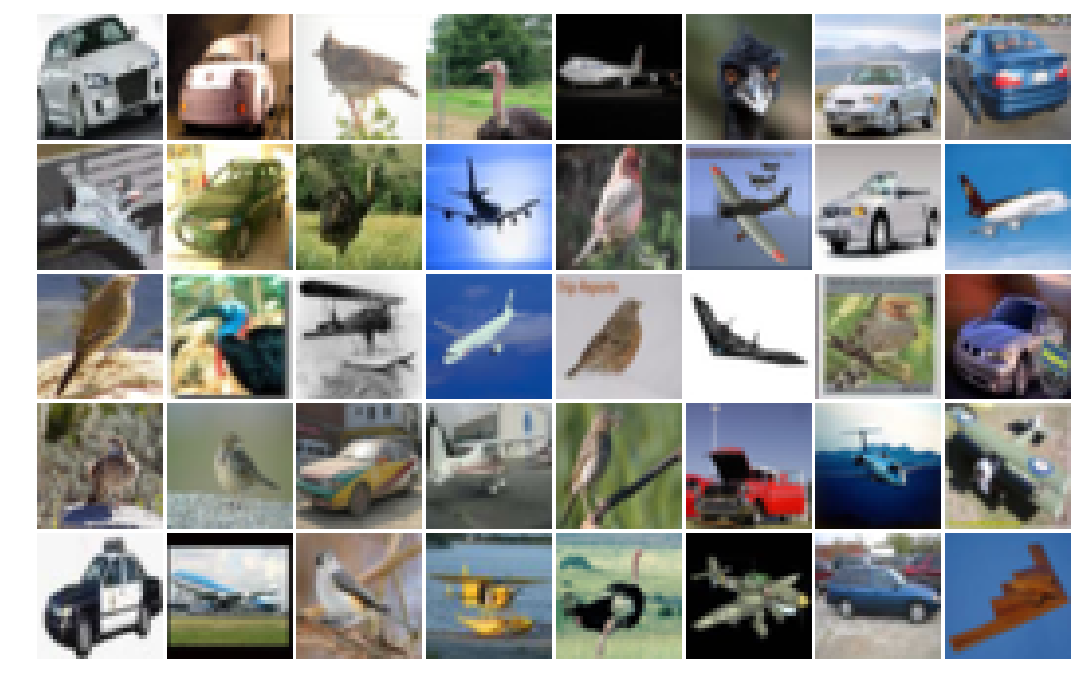

In [37]:
plt.figure(figsize=(24, 12))
n_samples = 40

# cria um DataLoader temporario para mostrar as imagens
temp_dataloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=n_samples,
                                              shuffle=True, num_workers=4)

# cria um grid com as imagens
grid = torchvision.utils.make_grid(next(iter(temp_dataloader))[0], normalize=True, pad_value=1.0, padding=1)

plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Teste inicial com pouquíssimas amostras

In [29]:
testing = False
if testing:
    n_samples = np.int(2*1280*(1+0.34))
    image_datasets['train'].train_data = image_datasets['train'].train_data[:n_samples]
    image_datasets['train'].train_labels = image_datasets['train'].train_labels[:n_samples]
    
    n_samples_test = 500
    image_datasets['val'].test_data = image_datasets['val'].test_data[:n_samples_test]
    image_datasets['val'].test_labels = image_datasets['val'].test_labels[:n_samples_test]

## Cria o DataLoader para os dados

In [30]:
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                                             for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print('Tamanho do conjunto de treinamento:', dataset_sizes['train'])
print('Tamanho do conjunto de validacao:', dataset_sizes['val'])
print('Classes:', class_names)

Tamanho do conjunto de treinamento: 15000
Tamanho do conjunto de validacao: 3000
Classes: ['airplane' 'automobile' 'bird']


# Construíndo a CNN com o PyTorch

In [31]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', nn.ReLU()),
            ('max_pool', nn.MaxPool2d(2)),
            ('drop', nn.Dropout(p=0.25))
        ]))
        
        # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(in_features=14*14*32, out_features=128)),
            ('relu1', nn.ReLU()),
            ('drop1', nn.Dropout(p=0.5)),
            ('dense2', nn.Linear(in_features=128, out_features=3)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 14*14*32)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x

In [32]:
model = MyModel()
print(model)

MyModel (
  (conv_layer): Sequential (
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU ()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU ()
    (max_pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (drop): Dropout (p = 0.25)
  )
  (dense_layer): Sequential (
    (dense1): Linear (6272 -> 128)
    (relu1): ReLU ()
    (drop1): Dropout (p = 0.5)
    (dense2): Linear (128 -> 3)
  )
)


## Código de apoio ao treinamento

In [33]:
class DeepNetTrainer:
    
    def __init__(self, file_basename=None, model=None, criterion=None, metrics=None, 
                 optimizer=None, lr_scheduler=None, reset=False):
        assert (model is not None) and (criterion is not None) and (optimizer is not None)
        self.basename = file_basename
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = lr_scheduler
        self.metrics = dict(train=dict(losses=[]), valid=dict(losses=[]))
        self.compute_metric = dict()
        
        if metrics is not None:
            for name, funct in metrics.items():
                self.metrics['train'][name] = []
                self.metrics['valid'][name] = []
                self.compute_metric[name] = funct
        
        if (self.basename is not None) and (not reset) and (os.path.isfile(self.basename + '.model')):
            self.load_trainer_state(self.basename, self.model, self.optimizer, self.metrics)
            print('Model loaded from', self.basename + '.model')
            
        self.last_epoch = len(self.metrics['train']['losses'])
        if self.scheduler is not None:
            self.scheduler.last_epoch = self.last_epoch
            
    def fit(self, n_epochs, train_data, valid_data=None):
        data = dict(train=train_data, valid=valid_data)
        if valid_data is None:
            phases = [('train', True)]
        else:
            phases = [('train', True), ('valid', False)]
            
        try:
            best_model = copy.deepcopy(model)
            best_loss = 1e10
            best_epoch = self.last_epoch

            print('Starting training for {} epochs'.format(n_epochs))
            for i in range(self.last_epoch + 1, self.last_epoch + n_epochs + 1):
                t0 = time.time()
                
                for phase, is_train in phases:
                
                    epo_samp = 0
                    epo_loss = 0
                    epo_metrics = dict([(n, 0) for n in self.compute_metric.keys()])
                    
                    self.model.train(is_train)
                    if is_train:
                        self.scheduler.step()

                    for ii, (X, Y) in enumerate(data[phase]):
                        if use_gpu:
                            X, Y = Variable(X.cuda()), Variable(Y.cuda())
                        else:
                            X, Y = Variable(X), Variable(Y)

                        Ypred = model.forward(X)
                        loss = self.criterion(Ypred, Y)
                        if is_train:
                            self.optimizer.zero_grad()
                            loss.backward()
                            self.optimizer.step()

                        epo_loss += loss.data.cpu().numpy()
                        epo_samp += 1

                        for name, fun in self.compute_metric.items():
                            metric = fun(Ypred.data, Y.data)
                            epo_metrics[name] += metric

                    eloss = float(epo_loss / epo_samp)
                    self.metrics[phase]['losses'].append(eloss)
                    
                    for name, fun in self.compute_metric.items():
                        metric = float(epo_metrics[name] / epo_samp)
                        self.metrics[phase][name].append(metric)

                if valid_data is None:
                    self.metrics['valid']['losses'].append(None)
                    for name, fun in self.compute_metric.items():
                        self.metrics['valid'][name].append(None)
                        
                is_best = ''
                if eloss < best_loss:
                    is_best = 'best'
                    best_loss = eloss
                    best_epoch = i
                    best_model = copy.deepcopy(model)
                    if self.basename is not None:
                        self.save_trainer_state(self.basename, self.model, self.optimizer, self.metrics)

                if (valid_data is not None) and (len(self.compute_metric) > 0):
                    # validation and metrics
                    mtrc = list(self.compute_metric.keys())[0]
                    print('{:3d}: {:5.1f}s  T: {:10.5f} {:5.2f}  V: {:10.5f} {:5.2f} {}'
                          .format(i, time.time() - t0, 
                                  self.metrics['train']['losses'][-1], self.metrics['train'][mtrc][-1],
                                  self.metrics['valid']['losses'][-1], self.metrics['valid'][mtrc][-1], is_best))
                elif (valid_data is not None):
                    # validation and no metrics
                    print('{:3d}: {:5.1f}s  T: {:10.5f}  V: {:10.5f} {}'
                          .format(i, time.time() - t0, self.metrics['train']['losses'][-1], 
                                                       self.metrics['valid']['losses'][-1], is_best))
                elif (valid_data is None) and (len(self.compute_metric) > 0):
                    # no validation and metrics
                    mtrc = list(self.compute_metric.keys())[0]
                    print('{:3d}: {:5.1f}s  T: {:10.5f} {:5.2f} {}'
                          .format(i, time.time() - t0, self.metrics['train']['losses'][-1], 
                                                       self.metrics['train'][mtrc][-1], is_best))
                else:
                    # no validation and no metrics
                    print('{:3d}: {:5.1f}s  T: {:10.5f} {}'
                          .format(i, time.time() - t0, self.metrics['train']['losses'][-1], is_best))
                
                t0 = time.time()

        except KeyboardInterrupt:
            print('Interrupted!!')

        print('\nModel from epoch {} saved as {}.*, loss = {:.5f}'.format(best_epoch, self.basename, best_loss))

    @staticmethod
    def load_trainer_state(file_basename, model, optimizer, metrics):
        model.load_state_dict(torch.load(file_basename + '.model'))
        if os.path.isfile(file_basename + '.optim'):
            optimizer.load_state_dict(torch.load(file_basename + '.optim'))
        if os.path.isfile(file_basename + '.histo'):
            metrics.update(pickle.load(open(file_basename + '.histo', 'rb')))
    
    @staticmethod
    def save_trainer_state(file_basename, model, optimizer, metrics):
        torch.save(model.state_dict(), file_basename + '.model')
        torch.save(optimizer.state_dict(), file_basename + '.optim')
        pickle.dump(metrics, open(file_basename + '.histo', 'wb'))

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Treinamento da rede

In [35]:
model = MyModel()
if use_gpu:
    model = model.cuda()

model.train(True)
# Calcula o erro pela CrossEntropy
criterion = nn.CrossEntropyLoss()
# Otimizador
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2844 Acc: 0.3333
val Loss: 0.2756 Acc: 0.3333

Epoch 1/9
----------
train Loss: 0.2863 Acc: 0.3268
val Loss: 0.2754 Acc: 0.3333

Epoch 2/9
----------
train Loss: 0.2849 Acc: 0.3363
val Loss: 0.2984 Acc: 0.3333

Epoch 3/9
----------
train Loss: 0.2853 Acc: 0.3368


Process Process-232:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Process Process-231:
Process Process-229:
Process Process-230:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/erick/.virtualenvs/jupiter/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/

KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/erick/.virtualenvs/jupiter/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/erick/.virtualenvs/jupiter/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_b

In [131]:
model = MyModel()
if use_gpu:
    model = model.cuda()
    
# Calcula o erro pela CrossEntropy
criterion = nn.CrossEntropyLoss()
# Otimizador
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def accuracy(out, y):
    _, y_hat = torch.max(out, 1)
    return torch.sum(y_hat==y)/y_hat.size(0)

metrics = {'acc': accuracy}

trainer = DeepNetTrainer(file_basename='../data/cifar_1', 
                         model=model, 
                         criterion=criterion, 
                         optimizer=optimizer, 
                         lr_scheduler=exp_lr_scheduler,
                         metrics=metrics,
                         reset=True)

In [132]:
trainer.fit(n_epochs=25, train_data=dataloders['train'], valid_data=dataloders['val'])

Starting training for 25 epochs
  1:   8.4s  T:    1.26036  0.33  V:    1.13061  0.33 best
  2:   8.3s  T:    1.25513  0.33  V:    1.19859  0.33 
  3:   8.8s  T:    1.25251  0.33  V:    1.29583  0.33 
  4:   8.2s  T:    1.25429  0.33  V:    1.20698  0.33 
  5:   8.6s  T:    1.24642  0.33  V:    1.14153  0.33 
  6:   8.4s  T:    1.24454  0.33  V:    1.13376  0.33 
  7:   8.9s  T:    1.11046  0.33  V:    1.09876  0.33 best
  8:   8.3s  T:    1.11020  0.34  V:    1.11359  0.33 
  9:   8.5s  T:    1.11019  0.34  V:    1.10010  0.33 


Process Process-1106:


Interrupted!!

Model from epoch 7 saved as ../data/cifar_1.*, loss = 1.09876


Process Process-1107:
Process Process-1108:
Process Process-1105:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/erick/.virtualenvs/jupiter/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/erick/.virtualenvs/jupiter/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_q

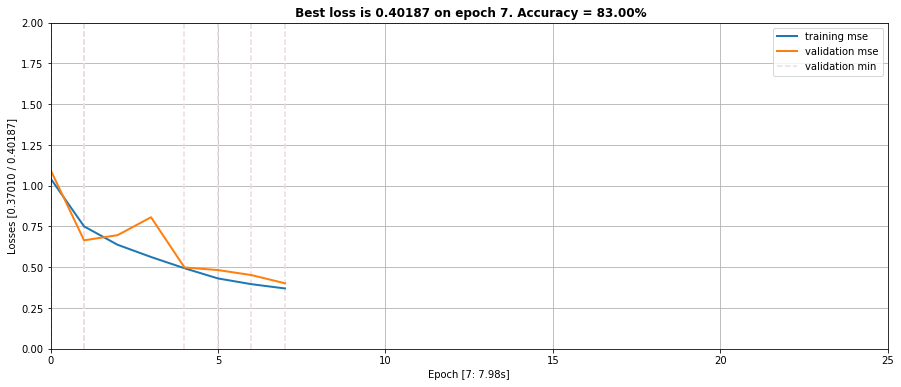

In [11]:
model_name = '../../models/cifar_1'
fit_params = {
    'model_name': model_name,
    'loss':       'categorical_crossentropy',
    'opt':        RMSprop(),
    'batch_size': 100, 
    'nepochs':    25,
    'patience':   5,
    'ploss':      2.,
    'reset':      False,
}

model_trained,_ = train_network(model, X_train, y_train_oh, X_test, y_test_oh, **fit_params);

## Avaliação do treinamento no conjunto de testes

In [12]:
def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

In [13]:
test_network(model_name, X_test, y_test_oh)

Model from epoch 7
[INFO] evaluating in the test data set ...
500/500 [==============================] - 0s     

[INFO] accuracy on the test data set: 83.00% [0.40187]


In [14]:
print('Rótulos conj. teste:',y_test[:10])
y_hat = model_trained.predict_classes(X_test[:10],verbose=0)
print('Rótulos previstos:  ',y_hat[:10])
y_prob = model_trained.predict_proba(X_test[:10],verbose=0)
print('probabilidades:\n',y_prob.max(axis=1))

Rótulos conj. teste: [0 1 1 0 0 2 0 2 1 0]
Rótulos previstos:   [0 1 1 0 0 2 2 1 1 0]
probabilidades:
 [ 0.87298018  0.82577163  0.99573404  0.88879097  0.80634588  0.97049123
  0.81984913  0.66382974  0.91772717  0.97208142]


In [15]:
y_prob = model_trained.predict_proba(X_test,verbose=0).max(axis=1)
y_hat = model_trained.predict_classes(X_test,verbose=0)
acc = (y_hat == y_test).sum()/y_hat.size
print('Acurácia:', acc)

Acurácia: 0.83


## Predições certas com maior probabilidade

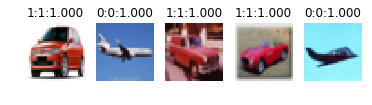

In [16]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]
for k,i in enumerate(y_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i].transpose((1,2,0)))
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições certas com menor probabilidade

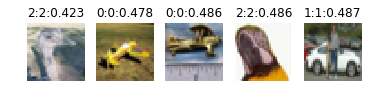

In [17]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
for k,i in enumerate(y_bot5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i].transpose((1,2,0)))
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com maior probabilidade

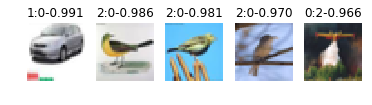

In [18]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]

for k,i in enumerate(y_most_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i].transpose((1,2,0)))
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com menor probabilidade

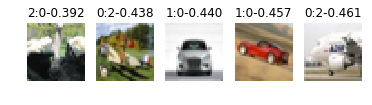

In [19]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]

for k,i in enumerate(y_least_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i].transpose((1,2,0)))
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Função que coloca várias imagens na forma de mosaico

In [20]:
def mosaic(f,N):
    n_images,h,w = f.shape
    nLines = np.int(np.ceil(float(n_images)/N))
    nCells = nLines*N
        
    fullf = np.resize(f, (nCells,h,w))
    fullf[n_images:nCells,:,:] = 0        
        
    Y,X = np.indices((nLines*h,N*w))
    Pts = np.array([
                   (np.floor(Y/h)*N + np.floor(X/w)).ravel(),
                   np.mod(Y,h).ravel(),
                   np.mod(X,w).ravel() ]).astype(int).reshape((3,int(nLines*h),int(N*w)))
    g = fullf[Pts[0],Pts[1],Pts[2]]
    return g

## Visualização de uma amostra

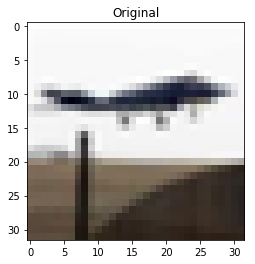

In [21]:
sn = 70  # amostra de número 70
plt.figure()
plt.imshow(X_test[sn].transpose((1,2,0)))
#plt.axis('off')
plt.title("Original");

## Visualização das camadas internas

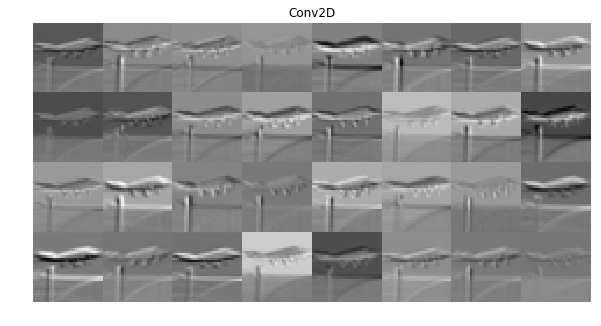

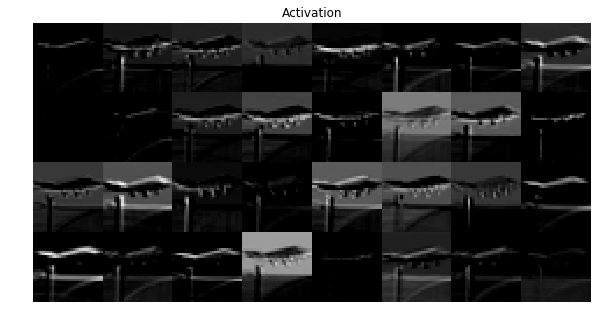

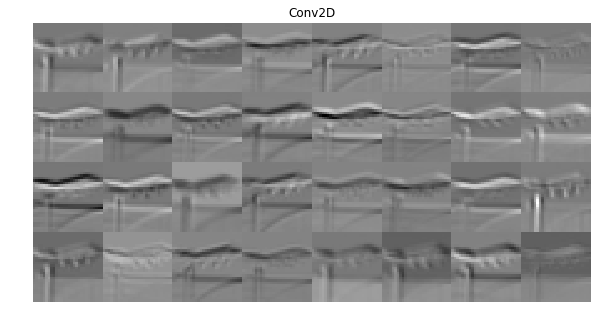

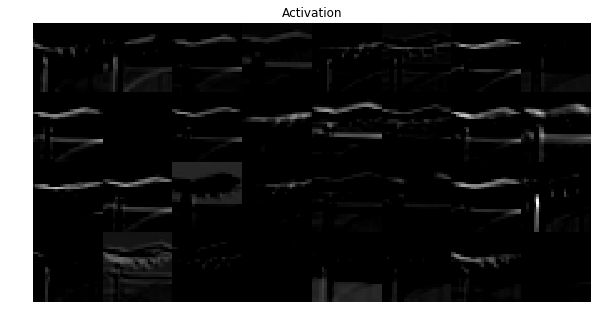

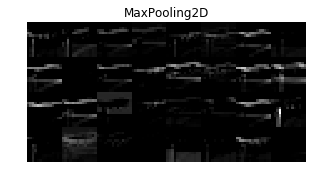

In [22]:
ncols = 8
H,W = 10,30

#Mostrando a saida das camadas convolucionais
for layer in model_trained.layers[0:5]:
    i_model = Model(inputs=model_trained.input,outputs=layer.output)
    i_output = i_model.predict(X_test[sn].reshape(1,3,32,32))
    sub_dim = i_output.shape[1]
    name = str(layer).split('.')[3].split(" ")[0]
    if name =="MaxPooling2D":
        H = H//2
        W = W//2
    fig =plt.figure(figsize=(H,W))
    aux = i_output[0,:,:,:]
    mos = mosaic(aux,ncols)
    plt.imshow(mos,cmap = 'gray')
    plt.axis('off')
    plt.title(name)

## Atividades

1. Quantos parâmetros são treinados nesta rede? Calcule o número de parâmetros de cada camada, não se esquecendo do *bias*. Confira o valor calculado com o `summary` do Keras.
2. Se as duas camadas convolucionais fossem densas, qual seria o número de parâmetros a serem treinados?
3. Altere o notebook para que ele seja processado na formato de imagens "channels_last".

## Aprendizados com este experimento
